## Importing required libraries 

In [1]:
import torch
import torchvision
from PIL import Image, ImageDraw
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import random

## Specifying the categories names in MS COCO Dataset

In [2]:
__COCO_INSTANCE_CATEGORY_NAMES__ = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

## Defining the instance segmentattion class 

In [3]:
class InstanceSegmentation(object):

    def __init__(self, model, image):

        """
        Parameters:
        - model: pre-trained model to be used for instance segmentation
        - image: PIL image input
        """

        self.model = model.eval()
        self.image = image

    def get_prediction(self, threshold):

        img = self.image
        transform = T.Compose([T.ToTensor()])
        img = transform(img)

        pred = self.model([img])
        pred_score = list(pred[0]['scores'].detach().numpy())
        pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]

        masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()

        pred_class = [__COCO_INSTANCE_CATEGORY_NAMES__[i] for i in list(pred[0]['labels'].numpy())]
        pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
        masks = masks[:pred_t+1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]

        return masks, pred_boxes, pred_class

    def random_colour_masks(self, mask):

        colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

        r = np.zeros_like(mask).astype(np.uint8)
        g = np.zeros_like(mask).astype(np.uint8)
        b = np.zeros_like(mask).astype(np.uint8)

        r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
        coloured_mask = np.stack([r, g, b], axis=2)

        return coloured_mask

    def instance_segmentation(self, threshold=0.5, rect_th=1, text_size=1, text_th=1):

        masks, boxes, pred_cls = self.get_prediction(threshold)
        img = self.image.convert('RGB')

        for i in range(len(masks)):
            rgb_mask = self.random_colour_masks(masks[i])
            img = Image.blend(img, Image.fromarray(rgb_mask), 0.5)
            img1 = ImageDraw.Draw(img)  
            img1.rectangle([(boxes[i][0]),(boxes[i][1])], outline ="red", width=1)

        return img

## Testing an image

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


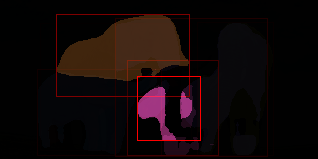

In [6]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
image = Image.open('/test.jpg')
ins_seg = InstanceSegmentation(model, image)
ins_seg.instance_segmentation()